This google colab notebook introduces basic Image Processing Methods require to perform template matching to extract the cheque number from a given cheque.

In [43]:
# import the necessary packages
from skimage.segmentation import clear_border
import imutils
from imutils import contours
import numpy as np
import argparse
import cv2
import matplotlib.pyplot as plt
# from google.colab.patches import cv2_imshow

## Function to extract the digits and symbols from a given list of character contours.

In [44]:
def extract_digits_and_symbols(image, charCnts, minW=5, minH=15):
	# grab the internal Python iterator for the list of character
	# contours, then  initialize the character ROI and location
	# lists, respectively
	charIter = charCnts.__iter__()
	rois = [] # regions of interests in the image
	locs = []	# locations of the regions of interest
	# keep looping over the character contours until we reach the end
	# of the list
	while True:
		try:
			# grab the next character contour from the list, compute
			# its bounding box, and initialize the ROI
			c = next(charIter)
			(cX, cY, cW, cH) = cv2.boundingRect(c)	# gives the four  important parameters of the image
			roi = None

			# check to see if the width and height are sufficiently
			# large, indicating that we have found a digit and not the letters at the end
			if cW >= minW and cH >= minH:
				# extract the ROI
				# cX : 

				roi = image[cY:cY + cH, cX:cX + cW]
				rois.append(roi)
				locs.append((cX, cY, cX + cW, cY + cH)) # the two diagnol corners of the bounding box of the ROI
			# otherwise, we are examining one of the special symbols
			else:
				# MICR symbols include three separate parts, so we
				# need to grab the next two parts from our iterator,
				# followed by initializing the bounding box
				# coordinates for the symbol
				parts = [c, next(charIter), next(charIter)]
				(sXA, sYA, sXB, sYB) = (np.inf, np.inf, -np.inf,
					-np.inf) # would be the diagnol values of the box of the letters
				# loop over the parts
				for p in parts:
					# compute the bounding box for each part, then
					# update our bookkeeping variables
					(pX, pY, pW, pH) = cv2.boundingRect(p)
					sXA = min(sXA, pX)
					sYA = min(sYA, pY)
					sXB = max(sXB, pX + pW)
					sYB = max(sYB, pY + pH)
				# extract the ROI
				roi = image[sYA:sYB, sXA:sXB]
				rois.append(roi)
				locs.append((sXA, sYA, sXB, sYB))
		# we have reached the end of the iterator; gracefully break
		# from the loop
		except StopIteration:
			break
	# return a tuple of the ROIs and locations
	return (rois, locs)    

## Lets have a query image and a reference image.


Reference image consists of all the characters possible in a cheque number to compare later with the query image.

In [45]:
reference = "../Material/MICR_reference.jpg"
query = "../Material/query_cheque_1.jpg"

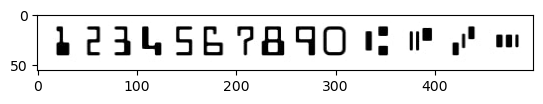

In [46]:
reference_image = cv2.imread(reference)
plt.imshow(reference_image)
# cv2.waitKey(0)


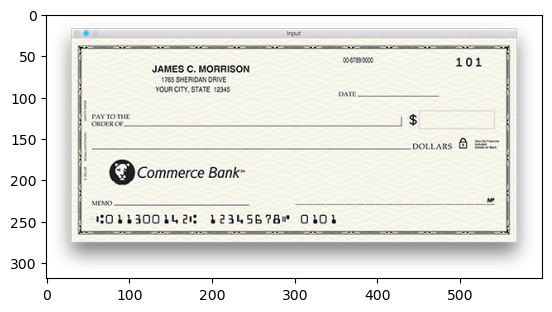

In [47]:
query_image = cv2.imread(query)
plt.imshow(query_image)


Initializing a list of reference character names in the same order as they appear in the reference image, in order to map them.

In [48]:
# initialize the list of reference character names, in the same
# order as they appear in the reference image where the digits
# their names and:
# T = Transit (delimit bank branch routing transit #)
# U = On-us (delimit customer account number)
# A = Amount (delimit transaction amount)
# D = Dash (delimit parts of numbers, such as routing or account)
charNames = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "0",
	"T", "U", "A", "D"]

# **STEP:1** Extracting the required bounding boxes from the reference image.

Converting the reference image to grayscale, and thresholding it, such that the digits appear as **white** on a **black** background.

(This conversion will be useful in later part)

In [49]:
# cv2.threshold
# Parameters: 
# -> source: Input Image array (must be in Grayscale). 
# -> thresholdValue: Value of Threshold below and above which pixel values will change accordingly. 
# -> maxVal: Maximum value that can be assigned to a pixel. 
# -> thresholdingTechnique: The type of thresholding to be applied. 

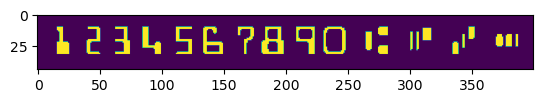

In [50]:
ref = cv2.imread(reference)
ref = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)
ref = imutils.resize(ref, width=400)
ref = cv2.threshold(ref, 120, 255, cv2.THRESH_BINARY_INV)[1]
plt.imshow(ref)

Detect the contours in the reference image (i.e,. the outlines of the characters) and sort them from left to right.

Contours can be explained simply as a curve joining all the continuous points (along the boundary), having same color or intensity. The contours are a useful tool for shape analysis and object detection and recognition. For better accuracy, use binary images.

In [51]:
# cv2.findContours
# Parameters:
# -> source: Input Image array (preferably thresholded image for best results)
# -> mode: (Contour retrieval mode) retrieves only the extreme outer contours.
# -> method: (Contour approximation method) compresses horizontal, vertical, and diagonal segments and leaves only their end points. For example, an up-right rectangular contour is encoded with 4 points.

In [52]:
refCnts = cv2.findContours(ref.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)

# print(refCnts) # tuple of contours and something something
# retrieve external : extracts only the outside  contours
# chain approx simple : gives only the four external contour points

refCnts = imutils.grab_contours(refCnts) # returns only the contours from the tuple (could have just done refCnts[1])


refCnts = contours.sort_contours(refCnts, method="left-to-right")[0] 


In [53]:
print(len(refCnts)) # since we have 22 contours (1,2,3,4,5,5,6,7,8,9,0, 3 for first, 3 for next, 3 for next, 3 for next)

22


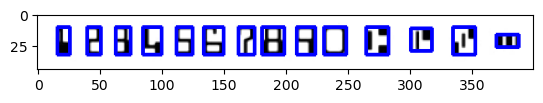

In [54]:
# extract the digits and symbols from the list of contours, then
# initialize a dictionary to map the character name to the ROI
refROIs, refLOCs = extract_digits_and_symbols(ref, refCnts,	minW=10, minH=20)
# print(refLOCs)
ref_copy = imutils.resize(reference_image.copy(), width=400)
for (x1,y1,x2,y2) in refLOCs:
  cv2.rectangle(ref_copy, (x1, y1),(x2, y2), (0, 0, 255), 2) 
  # 0,0,255 is the colour red
  # 2 defines the width of the rectangle box
  
plt.imshow(ref_copy)

# **STEP:2** Map the extracted bounding boxes to the reference image characters.

In [55]:
chars = {}
# loop over the reference ROIs
for (name, roi) in zip(charNames, refROIs):
	# resize the ROI to a fixed size, then update the characters
	# dictionary, mapping the character name to the ROI
	roi = cv2.resize(roi, (36, 36)) 
	chars[name] = roi

# **STEP:3** Extracting all the contours from the cheque number of the query cheque image.

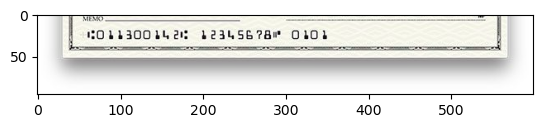

In [56]:
# load the input image, grab its dimensions, and apply array slicing
# to keep only certain portion of bottom of the image (that's where the account
# information is)
image = cv2.imread(query)
(h, w,) = image.shape[:2]
delta = int(h - (h * 0.3))
bottom = image[delta:h, 0:w]
plt.imshow(bottom)

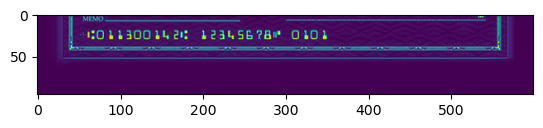

In [57]:
# initialize a rectangular kernel (wider than it is tall) along with
# an empty list to store the output of the check OCR
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 6))
output = []
# convert the bottom image to grayscale, then apply a blackhat
# morphological operator to find dark regions against a light
# background (i.e., the routing and account numbers)
gray = cv2.cvtColor(bottom, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel) # converts black to white and white to black
# temp_invrted = 255-gray
# plt.imshow(temp_invrted)
plt.imshow(blackhat)

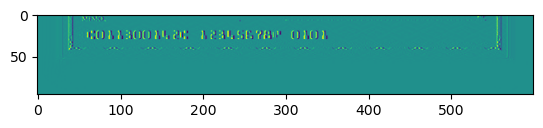

In [58]:
# compute the Scharr gradient of the blackhat image, then scale
# the rest back into the range [0, 255]
gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0,	
	ksize=1)# to remove the line below along with noise v 
plt.imshow(gradX)

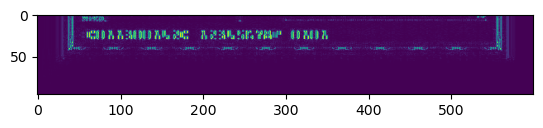

In [59]:
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
gradX = gradX.astype("uint8")
plt.imshow(gradX)

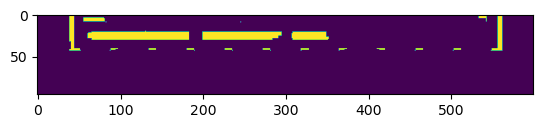

In [60]:
# apply a closing operation using the rectangular kernel to help
# cloes gaps in between rounting and account digits, then apply
# Otsu's thresholding method to binarize the image
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel) # close for closing after which any unnecessary dots will get removed
thresh = cv2.threshold(gradX, 120, 255,
	cv2.THRESH_BINARY)[1]
plt.imshow(thresh)

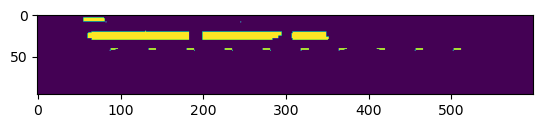

In [61]:
# remove any pixels that are touching the borders of the image (this
# simply helps us in the next step when we prune contours)
thresh = clear_border(thresh) # clear border 
plt.imshow(thresh)

[(61, 20, 123, 11), (200, 21, 96, 10), (308, 21, 45, 10)]


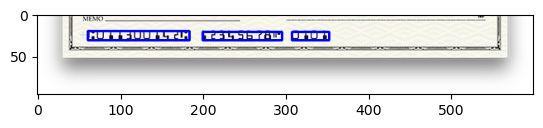

In [62]:
# find contours in the thresholded image, then initialize the
# list of group locations
groupCnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
groupCnts = imutils.grab_contours(groupCnts)
groupLocs = []
# loop over the group contours
for (i, c) in enumerate(groupCnts):
	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(c)
	# only accept the contour region as a grouping of characters if
	# the ROI is sufficiently large
	if w > 20 and h > 8:
		groupLocs.append((x, y, w, h))
# sort the digit locations from left-to-right
groupLocs = sorted(groupLocs, key=lambda x:x[0])
print(groupLocs)
image_copy = bottom.copy()
for (x1,y1,w1,h1) in groupLocs:
  cv2.rectangle(image_copy, (x1, y1),(x1+w1, y1+h1), (0, 0, 255), 2)
plt.imshow(image_copy)

# **STEP:4** Template matching the extracted contours

Check OCR: T011300142T 12345678U 0101
['T011300142T', '12345678U', '0101']


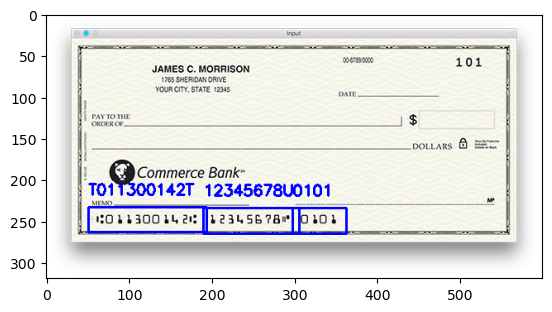

In [63]:
output=[]
# loop over the group locations
for (gX, gY, gW, gH) in groupLocs:
	# initialize the group output of characters
	groupOutput = []
	# extract the group ROI of characters from the grayscale
	# image, then apply thresholding to segment the digits from
	# the background of the credit card
	group = gray[gY - 5:gY + gH + 5, gX - 5:gX + gW + 5]
	# print(group)
	group = cv2.threshold(group, 0, 255,
		cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
	plt.imshow(group)
	cv2.waitKey(0)
	# find character contours in the group, then sort them from
	# left to right
	charCnts = cv2.findContours(group.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)
	charCnts = imutils.grab_contours(charCnts)
	charCnts = contours.sort_contours(charCnts,
		method="left-to-right")[0]
	# find the characters and symbols in the group
	(rois, locs) = extract_digits_and_symbols(group, charCnts,3,10)
	# print(len(rois))
	# loop over the ROIs from the group
	for roi in rois:
		# initialize the list of template matching scores and
		# resize the ROI to a fixed size
		scores = []
		roi = cv2.resize(roi, (36, 36))
		plt.imshow(roi)
		# loop over the reference character name and corresponding
		# ROI
		for charName in charNames:
			# apply correlation-based template matching, take the
			# score, and update the scores list
			result = cv2.matchTemplate(roi, chars[charName],
				cv2.TM_CCOEFF)
			# plt.imshow(result)
			(_, score, _, _) = cv2.minMaxLoc(result)
			scores.append(score)
		# the classification for the character ROI will be the
		# reference character name with the *largest* template
		# matching score
		groupOutput.append(charNames[np.argmax(scores)])    
		# print("groupOutput")    
		# print(groupOutput)    
	# draw (padded) bounding box surrounding the group along with
	# the OCR output of the group
	cv2.rectangle(image, (gX - 10, gY + delta - 10),
		(gX + gW + 10, gY + gY + delta), (0, 0, 255), 2)
	cv2.putText(image, "".join(groupOutput),
		(gX - 10, gY + delta - 25), cv2.FONT_HERSHEY_SIMPLEX,
		0.6, (0, 0, 255), 2)
	# add the group output to the overall check OCR output
	output.append("".join(groupOutput))  
 # display the output check OCR information to the screen
print("Check OCR: {}".format(" ".join(output)))
print(output)
plt.imshow(image)